## Business Analytics Concepts Airbnb Project

# Analyzing NYC Airbnb Marketing Trends

**Keith Faunce**

<br>

#### Given Data

This dataset contains all the information needed about the New York Airbnb listings.
It contains useful features such as latitude, longitude, room type, price, ratings, bedrooms, beds, baths, among others.

https://www.kaggle.com/datasets/vrindakallu/new-york-dataset

#### Additional Data

**NYPD Complaint Data**

This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to current, this dataset is updated annually.

https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data

**NYC Restaurant Inspection Results**

The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants.

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data

## Problem Statement

I am an Airbnb investor who wants to collect business insights as to what significance variables x, y, z have on NYC airbnb prices.

<br>

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import csv

In [2]:
filepath = r'C:\Users\Keith\MS_BA_sem_2\bus_ana_prac\project\new_york_listings_2024.csv'
unaltered_data = pd.read_csv(filepath)

In [3]:
unaltered_data.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.68371,-73.96461,Private room,55.0,...,2015-12-20,0.03,1,0,0,No License,5.0,1,1,Not specified


In [4]:
print(f"There are {unaltered_data['neighbourhood'].nunique()} different neighbourhoods, additional insights like neighbourhood safety; walkability, tourism appeal and others could be useful.")

There are 221 different neighbourhoods, additional insights like neighbourhood safety; walkability, tourism appeal and others could be useful.


In [5]:
print(f"There are {unaltered_data['neighbourhood_group'].nunique()} different neighbourhood groups")

There are 5 different neighbourhood groups


In [6]:
neighbourhoods_groups = unaltered_data["neighbourhood_group"].unique()
neighbourhoods_groups

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

In [7]:
neighbourhoods = unaltered_data["neighbourhood"].unique()
#neighbourhoods

In [8]:
unaltered_data.shape

(20758, 22)

In [9]:
unaltered_data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license', 'rating',
       'bedrooms', 'beds', 'baths'],
      dtype='object')

In [10]:
license_groups = unaltered_data['license'].unique()
#license_groups

In [11]:
(unaltered_data["license"].str.contains("No License", case=False, na=False)).sum()

np.int64(17569)

Almost 85% of License values in this dataset have **No License**. While this number may stand out it is not an alarm, NYC requires short term rentals (under 30 days) to have a permit only if the host is renting while the primary occupant is present.

<br>

## Pre-Processing

The column: **name** contains multiple fields of data, this function seperates those values and adds them to their respective columns if NULL.

In [12]:
def split_name(x):
    parts = [p.strip() for p in x.split("·")]
    rating = None
    bedrooms = None
    beds = None
    baths = None

    rating_pattern = re.compile(r"★?(\d\.\d+)")
    num_pattern = re.compile(r"(\d+)")

    for part in parts:
        r = rating_pattern.search(part)
        if r:
            rating = float(r.group(1))
            continue

        if "bedroom" in part:
            n = num_pattern.search(part)
            if n:
                bedrooms = int(n.group(1))
            continue
        if "bed" in part and "bedroom" not in part:
            n = num_pattern.search(part)
            if n:
                beds = int(n.group(1))
            continue
        if "bath" in part:
            n = num_pattern.search(part)
            if n:
                baths = int(n.group(1))
            continue

    return pd.Series([rating, bedrooms, beds, baths])

In [13]:
name_data = pd.DataFrame()
name_data[["rating", "bedrooms", "beds", "baths"]] = unaltered_data["name"].apply(split_name)

In [14]:
name_data.head(1)

,rating,bedrooms,beds,baths
0,5.0,1.0,NaN,NaN


In [15]:
unaltered_data["rating"] = unaltered_data["rating"].fillna(name_data["rating"])
unaltered_data["bedrooms"] = unaltered_data["bedrooms"].fillna(name_data["bedrooms"])
unaltered_data["beds"] = unaltered_data["beds"].fillna(name_data["beds"])
unaltered_data["baths"] = unaltered_data["baths"].fillna(name_data["baths"])

In [16]:
airbnb_data = unaltered_data.drop(["name", "host_name"], axis=1)

In [17]:
# Extreme price outlier removal
# This is one row
airbnb_data = airbnb_data[airbnb_data["price"] <= 80000]

In [18]:
bnb_rating = airbnb_data["rating"].unique()
#bnb_rating
airbnb_data["rating"] = airbnb_data["rating"].replace("No rating", np.nan)
airbnb_data["rating"] = airbnb_data["rating"].replace("New", np.nan)
airbnb_data["rating"] = airbnb_data["rating"].replace("New ", np.nan)
airbnb_data["baths"] = airbnb_data["baths"].replace("Not specified", np.nan)
airbnb_data["bedrooms"] = airbnb_data["bedrooms"].replace("Studio", np.nan)

In [19]:
airbnb_data.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license', 'rating', 'bedrooms', 'beds',
       'baths'],
      dtype='object')

## Additional Data

In [20]:
# NYPD Data
# This data has already been manipulated (kaggle preprocessing) to display insights from recent years, unrelated columns have already been removed
police_data = pd.read_csv(r'C:\Users\Keith\MS_BA_sem_2\bus_ana_prac\project\NYPD_Complaint_Data_Historic_20251128.csv')
# Food Inspection Data
# This data has already been manipulated (kaggle preprocessing) to display results from the valid time period, unrelated columms have already been removed
food_data = pd.read_csv(r'C:\Users\Keith\MS_BA_sem_2\bus_ana_prac\project\DOHMH_New_York_City_Restaurant_Inspection_Results_20251128.csv')

**Column Data**

**Police Data**

CMPLNT_FR_DT:	Exact date of occurrence for the reported event

RPT_DT:	Date the event was reported to police.

OFNS_DESC:	Description of the offense corresponding to the offense key code.

PD_DESC:	Internal NYPD classification description 

CRM_ATPT_CPTD_CD:	Indicates if the crime was completed (COMPLETED) or attempted (ATTEMPTED).

LAW_CAT_CD:	Offense level: felony, misdemeanor, or violation.

BORO_NM:	Name of the borough where the incident occurred.

PREM_TYP_DESC:	Description of the premises (street, residence, store, park, etc.)

PARKS_NM:	Name of NYC park/playground involved

HADEVELOPT:	Name of NYCHA housing development involved

Latitude:	Global latitude

Longitude:	Global longitude

Lat_Lon:	Combined latitude/longitude string 

PATROL_BORO:	Patrol borough responsible

STATION_NAME:	Transit station name (if incident occurred within the transit system).

**Food Data**

DBA:	“Doing Business As” the restaurant’s public name.

BORO:	Borough where the restaurant is located (Manhattan, Bronx, Brooklyn, Queens, Staten Island).

STREET:	Street name of the establishment.

ZIPCODE:	ZIP code of the establishment.

CUISINE DESCRIPTION:	Restaurant’s cuisine type (Pizza, Chinese, Japanese, Vegan, etc.)

INSPECTION DATE:	Date of the inspection. (1/1/1900 = never inspected yet.)

ACTION:	Summary action related to the inspection (e.g., violations cited, no violations, reopened, closed, etc.)

CRITICAL FLAG:	Whether the violation was critical (“Critical”, “Not Critical”, “Not Applicable”).

SCORE:	Numerical score for the inspection. Lower = better.

GRADE:	Official DOHMH grade assigned (A, B, C, Z, P, or N for “Not Yet Graded”).

GRADE DATE:	Date when the letter grade was issued.

RECORD DATE:	Date the dataset extract was generated (when the row was last updated).

Latitude:	Global latitude

Longitude:	Global longitude

Location:	Combined POINT field containing latitude & longitude.

In [21]:
print(f"The unaltered shape of police data is {police_data.shape}. The unaltered shape of food data is {food_data.shape}")

The unaltered shape of police data is (563430, 28). The unaltered shape of food data is (174834, 20)


In [22]:
police_data.head(1)

,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME
0,12/30/2024,23:00:00,12/31/2024,01:30:00,75,12/31/2024,341,PETIT LARCENY,339.0,"LARCENY,PETIT FROM OPEN AREAS,",...,(null),NaN,"1,018,639","184,199",NaN,40.672205,-73.876028,"(40.672205, -73.876028)",PATROL BORO BKLYN NORTH,(null)


In [23]:
police_groups = police_data["BORO_NM"].unique()
police_groups

array(['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND',
       '(null)'], dtype=object)

In [24]:
police_data["BORO_NM"] = police_data["BORO_NM"].replace("(null)", np.nan)
police_data = police_data.dropna(subset=["BORO_NM"])

In [25]:
police_data = police_data.drop(["ADDR_PCT_CD", "KY_CD", "PD_CD", "HOUSING_PSA", "TRANSIT_DISTRICT", "X_COORD_CD", "Y_COORD_CD", "JURIS_DESC", "LOC_OF_OCCUR_DESC", "CMPLNT_FR_TM", "CMPLNT_TO_DT", "CMPLNT_TO_TM"], axis=1)

In [26]:
food_data.head(1)

,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Location
0,REICHENBACH HALL,Manhattan,5,WEST 37 STREET,10018.0,2123027744,German,05/09/2024,Violations were cited in the following area(s).,09B,Thawing procedure improper.,Not Critical,10.0,A,05/09/2024,11/28/2025,Cycle Inspection / Re-inspection,40.750585,-73.983744,POINT (-73.983744126629 40.750585348897)


In [27]:
food_groups = food_data["BORO"].unique()
food_groups

array(['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island'],
      dtype=object)

In [28]:
food_data = food_data.drop(["BUILDING", "PHONE", "VIOLATION CODE", "INSPECTION TYPE", "VIOLATION DESCRIPTION"], axis=1)

In [29]:
print(f"The altered shape of police data is {police_data.shape}. The altered shape of food data is {food_data.shape}")

The altered shape of police data is (562599, 16). The altered shape of food data is (174834, 15)


In [30]:
police_data.columns

Index(['CMPLNT_FR_DT', 'RPT_DT', 'OFNS_DESC', 'PD_DESC', 'CRM_ATPT_CPTD_CD',
       'LAW_CAT_CD', 'BORO_NM', 'PREM_TYP_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'Latitude', 'Longitude', 'Lat_Lon',
       'PATROL_BORO', 'STATION_NAME'],
      dtype='object')

In [31]:
food_data.columns

Index(['DBA', 'BORO', 'STREET', 'ZIPCODE', 'CUISINE DESCRIPTION',
       'INSPECTION DATE', 'ACTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

<br>

## Visualizations

In [32]:
avg_price_neighbourhood = (airbnb_data.groupby(["neighbourhood_group", "neighbourhood"])["price"]
      .mean()
      .reset_index()
      .sort_values("price"))

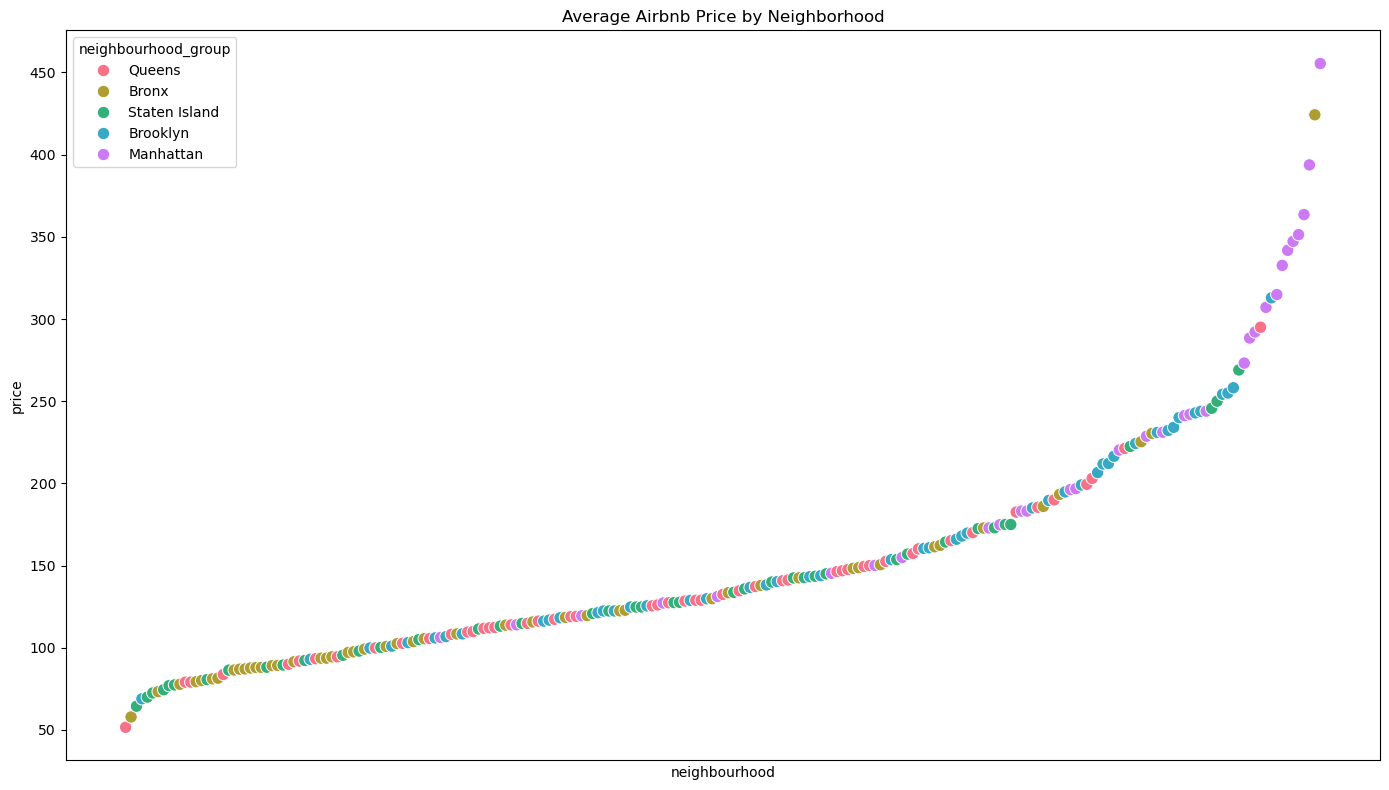

In [33]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=avg_price_neighbourhood, x="neighbourhood", y="price", hue="neighbourhood_group", palette="husl", s=80)
plt.xticks([])
plt.title("Average Airbnb Price by Neighborhood")
plt.tight_layout()

C:\Users\Keith\AppData\Local\Temp\ipykernel_28228\482425520.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=airbnb_data, x="neighbourhood_group", y="price", palette="husl")


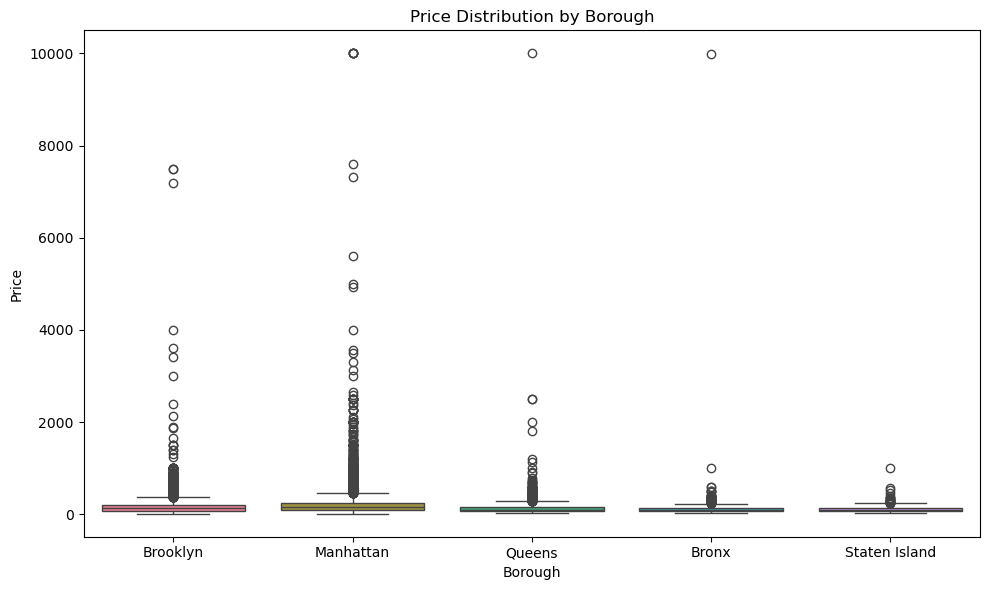

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_data, x="neighbourhood_group", y="price", palette="husl")
plt.title("Price Distribution by Borough")
plt.xlabel("Borough")
plt.ylabel("Price")
plt.tight_layout()

In [35]:
heatmap_cols = [
    "price",
    "reviews_per_month",
    "availability_365",
    "number_of_reviews",
    "rating",
    "beds",
    "baths",
    "bedrooms"
]

In [36]:
for col in heatmap_cols:
    if airbnb_data[col].dtype == object:
        print(col)

rating
baths
bedrooms


In [37]:
#airbnb_data['rating'].unique()
#airbnb_data['baths'].unique()
#airbnb_data['bedrooms'].unique()

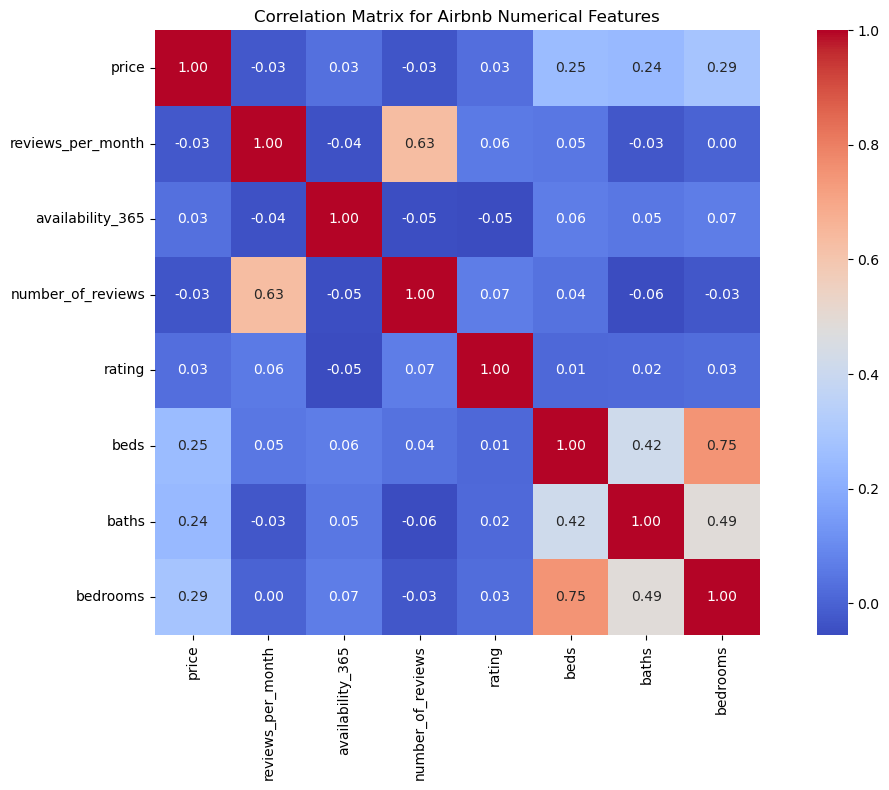

In [38]:
corr = airbnb_data[heatmap_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Airbnb Numerical Features")
plt.tight_layout()

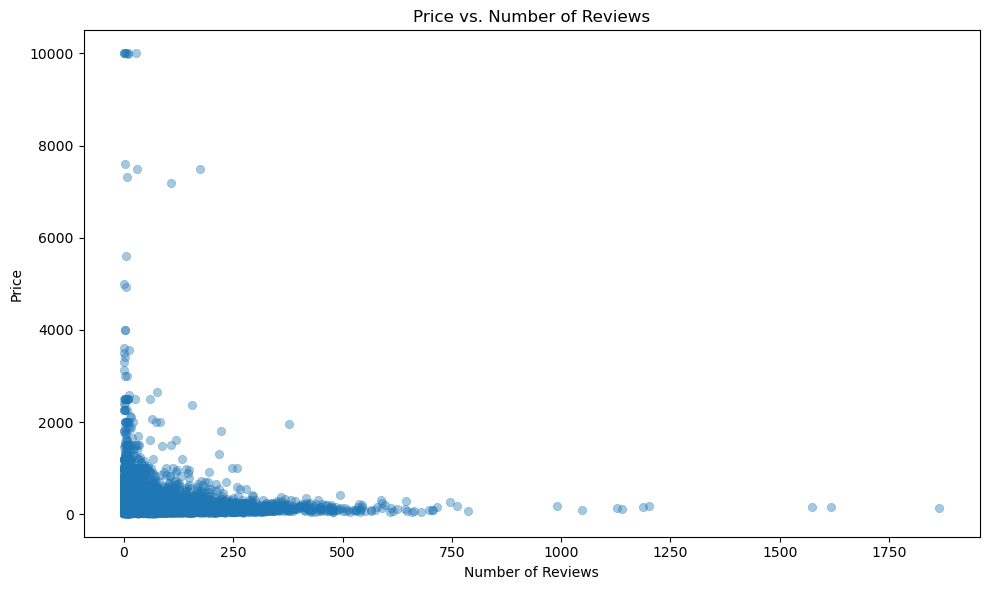

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=airbnb_data, x="number_of_reviews", y="price", alpha=0.4, edgecolor=None)
plt.title("Price vs. Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.tight_layout()

In [40]:
burrow_attempts = (police_data.groupby(["BORO_NM", "CRM_ATPT_CPTD_CD"])
      .size()
      .reset_index(name="count"))
pivot = burrow_attempts.pivot(index="BORO_NM", columns="CRM_ATPT_CPTD_CD", values="count")

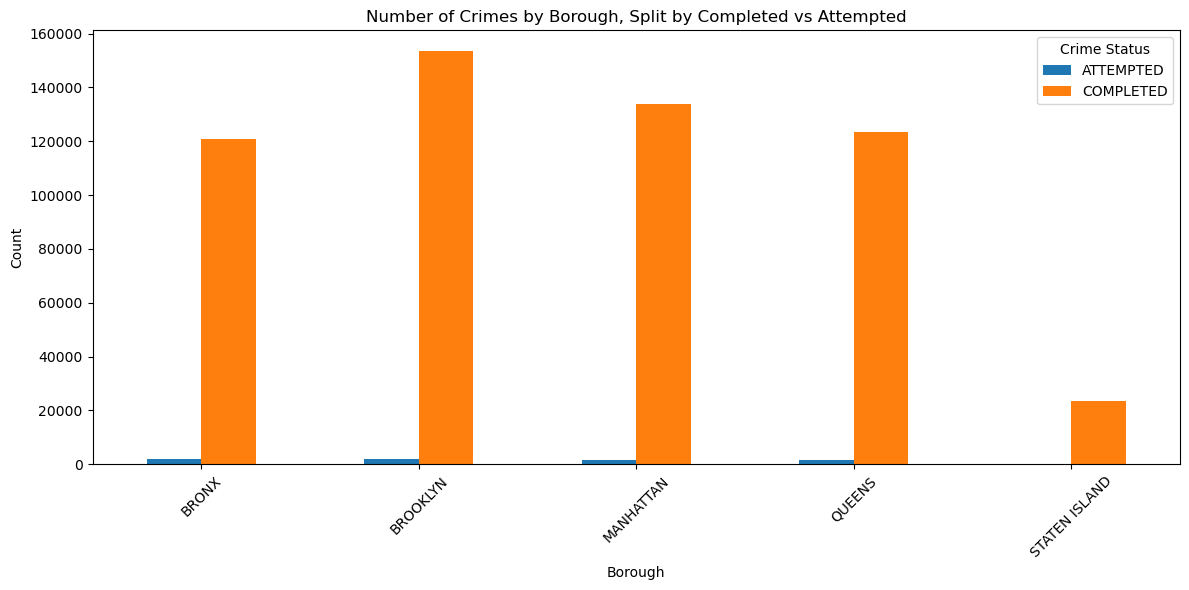

In [41]:
pivot.plot(kind="bar", figsize=(12, 6))
plt.title("Number of Crimes by Borough, Split by Completed vs Attempted")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Crime Status")
plt.tight_layout()

In [42]:
avg_scores = (
    food_data.groupby("BORO")["SCORE"]
      .mean()
      .reset_index()
      .sort_values("SCORE"))

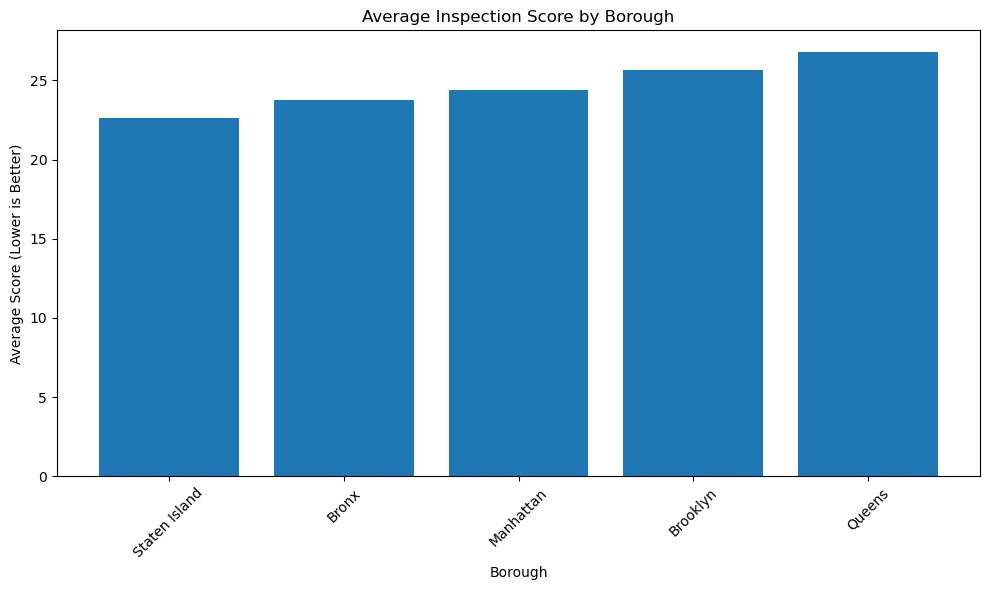

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(avg_scores["BORO"], avg_scores["SCORE"])
plt.title("Average Inspection Score by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Score (Lower is Better)")
plt.xticks(rotation=45)
plt.tight_layout()

In [44]:
airbnb_plot = airbnb_data.dropna(subset=["latitude", "longitude", "price"])
coords = airbnb_data[["latitude", "longitude"]].values
airbnb_plot["price_log"] = np.log1p(airbnb_plot["price"])
prices = airbnb_plot["price_log"].values

In [45]:
coords_rad = np.radians(coords)
db = DBSCAN(eps=0.005, min_samples=30, metric='haversine').fit(coords_rad)
airbnb_plot["cluster"] = db.labels_

Text(0, 0.5, 'Latitude')

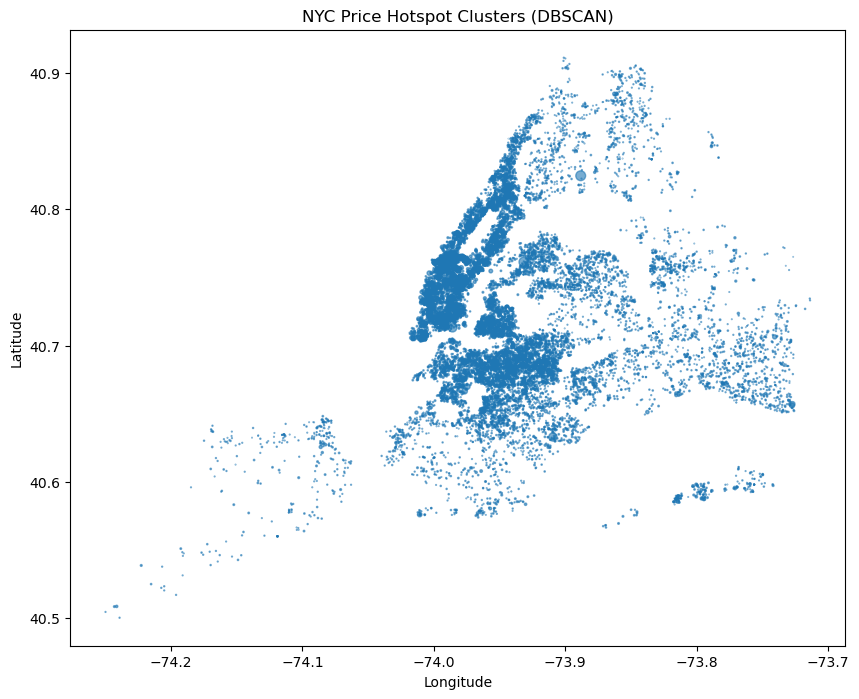

In [46]:
plt.figure(figsize=(10, 8))
plt.scatter(airbnb_plot["longitude"], airbnb_plot["latitude"], c=airbnb_plot["cluster"], cmap="tab20", s=airbnb_plot["price"] / airbnb_plot["price"].max() * 50, alpha=0.6)
plt.title("NYC Price Hotspot Clusters (DBSCAN)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [47]:
gdf = gpd.GeoDataFrame(airbnb_plot, geometry=gpd.points_from_xy(airbnb_plot["longitude"], airbnb_plot["latitude"]), crs="EPSG:4326")
gdf_web = gdf.to_crs(epsg=3857)

Text(0.5, 1.0, 'NYC Airbnb Price Hotspot Clusters (DBSCAN)')

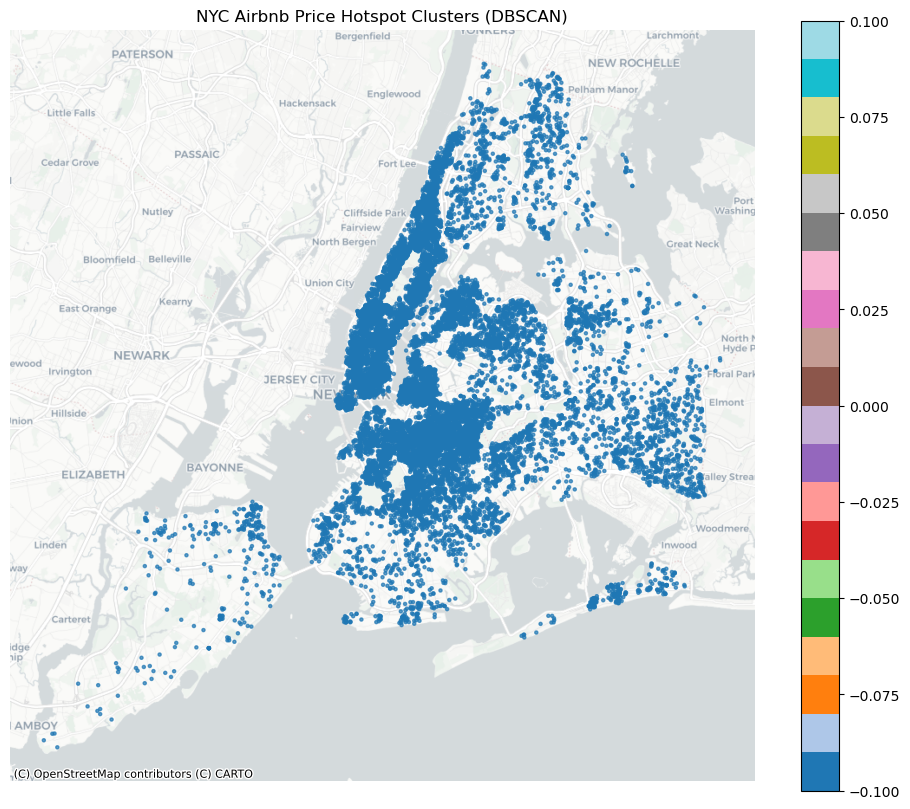

In [48]:
fig, ax = plt.subplots(figsize=(12, 10))

gdf_web.plot(ax=ax, column="cluster", markersize=5, cmap="tab20", legend=True, alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("NYC Airbnb Price Hotspot Clusters (DBSCAN)")

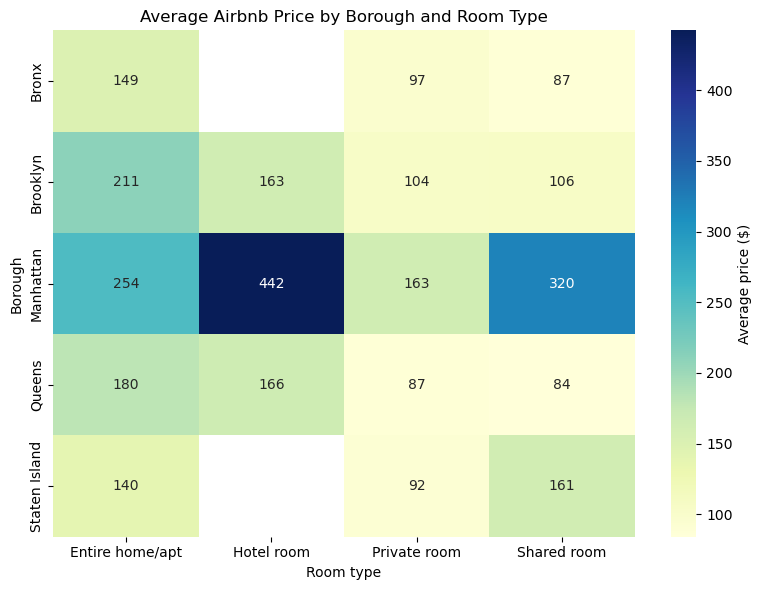

In [49]:
price_pivot = (
    airbnb_data
    .groupby(["neighbourhood_group", "room_type"])["price"]
    .mean()
    .reset_index()
    .pivot(index="neighbourhood_group", columns="room_type", values="price")
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    price_pivot,
    annot=True,        
    fmt=".0f",        
    cmap="YlGnBu",     
    cbar_kws={"label": "Average price ($)"}
)
plt.title("Average Airbnb Price by Borough and Room Type")
plt.xlabel("Room type")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()

<br>

## Analysis

### 1. Multiple Linear Regression

In [50]:
airbnb_data.head(1)

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,7130382,Brooklyn,Clinton Hill,40.68371,-73.96461,Private room,55.0,30,3,2015-12-20,0.03,1,0,0,No License,5.0,1,1,NaN


In [51]:
dummy_cols = ['neighbourhood_group', 'room_type']
bnb_sample = airbnb_data[['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'number_of_reviews_ltm', 'rating', 'bedrooms', 'beds', 'baths', 'price']].copy()

In [52]:
bnb_sample = pd.get_dummies(bnb_sample, columns=dummy_cols, drop_first=True)

In [53]:
bnb_sample = bnb_sample.dropna(subset=["rating", "bedrooms", "baths"])

In [54]:
print(f"The dataset that is being queried against the MLR model is missing about 4000 of the 20000 attributes due to NULL values. {bnb_sample.shape}")

The dataset that is being queried against the MLR model is missing about 4000 of the 20000 attributes due to NULL values. (15522, 17)


In [55]:
X = bnb_sample.copy()
y = bnb_sample['price']

In [56]:
X = X.drop(columns=['price'])

In [57]:
X = X.apply(pd.to_numeric, errors='coerce')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### MLR Results

In [59]:
coefficient_vals = pd.DataFrame({'feature': X.columns,'coefficient': model.coef_}).sort_values('coefficient', ascending=False)
coefficient_vals.head(16)

,feature,coefficient
13,room_type_Hotel room,163.240308
10,neighbourhood_group_Manhattan,93.085857
8,baths,71.439719
6,bedrooms,50.961655
5,rating,27.062263
9,neighbourhood_group_Brooklyn,18.294036
7,beds,18.229323
2,reviews_per_month,0.179014
3,availability_365,0.044378
1,number_of_reviews,-0.036741


In [60]:
X2 = X.copy()
bool_cols = X2.select_dtypes(include=['bool']).columns
X2[bool_cols] = X2[bool_cols].astype(int)

In [61]:
statX = sm.add_constant(X2)
modelX = sm.OLS(y, statX).fit()

In [62]:
print(modelX.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     146.8
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:29:34   Log-Likelihood:            -1.0909e+05
No. Observations:               15522   AIC:                         2.182e+05
Df Residuals:                   15505   BIC:                         2.183e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [63]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [64]:
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(bnb_sample[['price']]).ravel()

In [65]:
X_scaled = sm.add_constant(X_scaled)

stdized_model = sm.OLS(y_scaled, X_scaled).fit()

In [66]:
print(stdized_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     146.8
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:29:34   Log-Likelihood:                -20930.
No. Observations:               15522   AIC:                         4.189e+04
Df Residuals:                   15505   BIC:                         4.202e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.072e-18      0.007   8.11e-16      1.0

### 2. Anova Testing

In [67]:
anova_data = airbnb_data.copy()

In [68]:
police_data = police_data.rename(columns={"Latitude": "latitude", "Longitude": "longitude"})

In [69]:
police_data = police_data.dropna(subset=["latitude", "longitude"])

In [70]:
hood_centroids = (
    anova_data.groupby(["neighbourhood_group", "neighbourhood"])[["latitude", "longitude"]]
    .mean()
    .reset_index()
)
# hood_centroids

In [71]:
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nn.fit(hood_centroids[["latitude", "longitude"]])

distances, indices = nn.kneighbors(police_data[["latitude", "longitude"]])

police_data["neighbourhood"] = hood_centroids.loc[indices.flatten(), "neighbourhood"].values
police_data["neighbourhood_group"] = hood_centroids.loc[indices.flatten(), "neighbourhood_group"].values

In [72]:
crime_summary = (police_data.groupby("neighbourhood")
         .agg(
             crime_count=("CMPLNT_FR_DT", "count"),
             felony_count=("LAW_CAT_CD", lambda x: (x=="FELONY").sum())
         )
         .reset_index()
)
#crime_summary

In [73]:
food_data = food_data.rename(columns={"Latitude": "latitude", "Longitude": "longitude"})

In [74]:
food_data.isnull().sum()

DBA                        0
BORO                       0
STREET                     0
ZIPCODE                 1896
CUISINE DESCRIPTION        0
INSPECTION DATE            0
ACTION                     0
CRITICAL FLAG              0
SCORE                   7982
GRADE                  88761
GRADE DATE             92011
RECORD DATE                0
latitude                 727
longitude                727
Location                1896
dtype: int64

In [75]:
food_data = food_data.dropna(subset=["latitude", "longitude", "SCORE", "GRADE"])

In [76]:
dist, idx = nn.kneighbors(food_data[["latitude", "longitude"]])
food_data["neighbourhood"] = hood_centroids.loc[idx.flatten(), "neighbourhood"].values
food_data["neighbourhood_group"] = hood_centroids.loc[idx.flatten(), "neighbourhood_group"].values

In [77]:
food_summary = (food_data.groupby("neighbourhood")
        .agg(
            avg_score=("SCORE", "mean"),
            pct_A=("GRADE", lambda x: (x=="A").mean()),
            restaurant_count=("DBA", "count")
        )
        .reset_index()
)
#food_summary

In [78]:
merged_anova = (
    anova_data
    .merge(crime_summary, on="neighbourhood", how="left")
    .merge(food_summary, on="neighbourhood", how="left")
)

<br>

**In terms of scaling, the higher the crime_count the more dangerous the neighbourhood. But the higher the avg_score the worse a restaurants health quality is (low score better).**

<br>

In [79]:
merged_anova["safety_group"] = pd.qcut(merged_anova["crime_count"], 3, labels=["Low", "Medium", "High"])
merged_anova["restaurant_group"] = pd.qcut(merged_anova["avg_score"], 3, labels=["Low", "Medium", "High"])

In [80]:
price_low_safety = merged_anova.loc[merged_anova["safety_group"] == "Low", "price"]
price_med_safety = merged_anova.loc[merged_anova["safety_group"] == "Medium", "price"]
price_high_safety = merged_anova.loc[merged_anova["safety_group"] == "High", "price"]

In [81]:
f_stat_safety, p_val_safety = stats.f_oneway(price_low_safety, price_med_safety, price_high_safety)

print(f"The ANOVA analysis between price and safety rating has an F value of {f_stat_safety:.3f}, and a significant p value of {p_val_safety:.10f}")
print(f"Showcasing that neighbourhood safety does have an influence on price.")

The ANOVA analysis between price and safety rating has an F value of 17.089, and a significant p value of 0.0000000384
Showcasing that neighbourhood safety does have an influence on price.


In [82]:
tukey_safety = pairwise_tukeyhsd(endog=merged_anova["price"], groups=merged_anova["safety_group"], alpha=0.05)
print(tukey_safety)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  High    Low  25.2703    0.0  13.5146  37.026   True
  High Medium  25.5155    0.0  13.8268 37.2042   True
   Low Medium   0.2452 0.9987 -11.3724 11.8627  False
-----------------------------------------------------


Text(0.5, 1.0, 'Airbnb Prices Across Safety Groups')

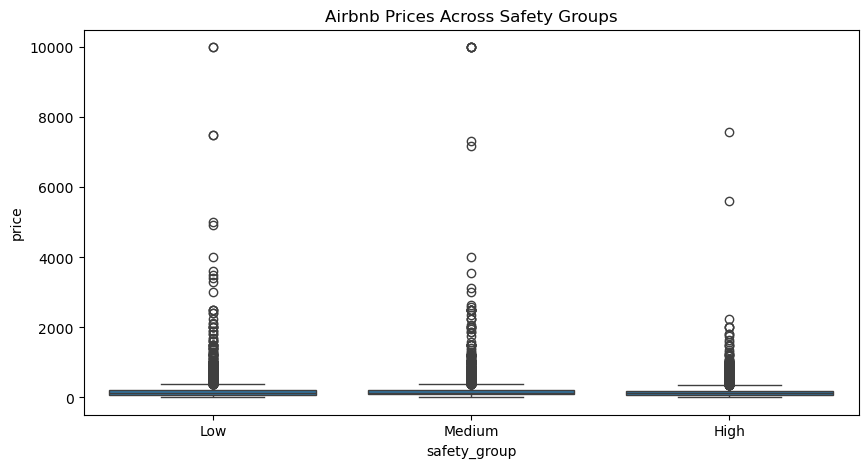

In [83]:
plt.figure(figsize=(10,5))
sns.boxplot(x="safety_group", y="price", data=merged_anova)
plt.title("Airbnb Prices Across Safety Groups")

In [84]:
merged_anova = merged_anova.dropna(subset=["restaurant_group"])

In [85]:
price_low_rest = merged_anova.loc[merged_anova["restaurant_group"] == "Low", "price"]
price_med_rest = merged_anova.loc[merged_anova["restaurant_group"] == "Medium", "price"]
price_high_rest = merged_anova.loc[merged_anova["restaurant_group"] == "High", "price"]

In [86]:
f_stat_rest, p_val_rest = stats.f_oneway(price_low_rest, price_med_rest, price_high_rest)

f_stat_rest, p_val_rest
print(f"The ANOVA analysis between price and restaurant quality rating has an F value of {f_stat_safety:.3f}, and a significant p value of {p_val_safety:.30f}")
print(f"Showcasing that neighbourhood restaurant quality does have an influence on price.")

The ANOVA analysis between price and restaurant quality rating has an F value of 17.089, and a significant p value of 0.000000038420367529904344952357
Showcasing that neighbourhood restaurant quality does have an influence on price.


In [87]:
tukey_rest = pairwise_tukeyhsd(endog=merged_anova["price"], groups=merged_anova["restaurant_group"], alpha=0.05)
print(tukey_rest)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  High    Low  50.5853    0.0  38.9367 62.2339   True
  High Medium  41.5922    0.0   29.897 53.2873   True
   Low Medium  -8.9931 0.1666 -20.6443   2.658  False
-----------------------------------------------------


Text(0.5, 1.0, 'Airbnb Prices Across Restaurant Quality Groups')

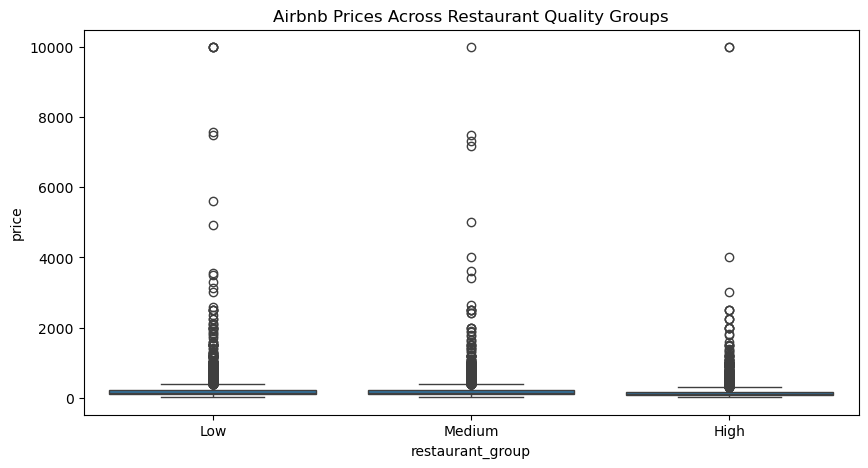

In [88]:
plt.figure(figsize=(10,5))
sns.boxplot(x="restaurant_group", y="price", data=merged_anova)
plt.title("Airbnb Prices Across Restaurant Quality Groups")

### 3. Panel Data Analysis

In [89]:
airbnb_data = airbnb_data.dropna(subset=["rating"])

In [90]:
airbnb_data["rating"] = airbnb_data["rating"].apply(pd.to_numeric, errors="coerce")

In [91]:
borough = airbnb_data.groupby("neighbourhood_group").agg({"reviews_per_month": "mean", "number_of_reviews_ltm": "mean", "price": "mean", "availability_365": "mean", "rating": "mean"}).reset_index()

In [92]:
panel = pd.melt(borough,
    id_vars=["neighbourhood_group", "price", "availability_365", "rating"],
    value_vars=["reviews_per_month", "number_of_reviews_ltm"],
    var_name="period",
    value_name="demand"
)

In [93]:
panel["t"] = panel["period"].map({"number_of_reviews_ltm": 0, "reviews_per_month": 1})

In [94]:
model = smf.ols("demand ~ t + price + availability_365 + rating + C(neighbourhood_group)", data=panel).fit()

In [95]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           0.000226
Time:                        17:29:41   Log-Likelihood:                -7.3323
No. Observations:                  10   AIC:                             26.66
Df Residuals:                       4   BIC:                             28.48
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------